# ANALISIS Y PROCESAMIENTO DEL DATAFRAME

In [1]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import seaborn as sns

# Criterio para calcular peso de popularidad: 10% cantidad de reseñas, 10% para su score, 30% cantidad copias vendidas, 50% tiempo desde año de lanzamiento 
def calculate_popularity(game_row):
    score = 0
    score += game_row['reviews'] * 0.1
    score += game_row['reviewScore'] * 0.1 
    score += game_row['copiesSold'] * 0.3  
    score += game_row['years_since_release'] * 0.5  
    return score

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    return None

dataset = pd.read_csv('./games_data_processed.csv', sep=',', usecols=lambda column: column not in ['steamId', 'developers', 'features', 'tags'])

df = dataset.copy()

df.drop_duplicates(keep=False, inplace=True)
df.dropna(subset=['releaseDate'], inplace=True)

df = df[(df['copiesSold'] >= 100000) & (df['copiesSold'] <= 30000000)]

publisher_review_counts = df.groupby('publishers')['copiesSold'].mean().reset_index()
publisher_review_counts.columns = ['publishers', 'avg_publisher_copies']

df = df.merge(publisher_review_counts, on='publishers', how='left')
df = df[df['avg_publisher_copies'].notna()]

df['releaseDate'] = pd.to_datetime(df['releaseDate'], format='%m/%Y', errors='coerce')
df['year'] = df['releaseDate'].dt.year
df['month'] = df['releaseDate'].dt.month
df['season'] = df['month'].apply(get_season)
current_year = pd.Timestamp.now().year
df['years_since_release'] = current_year - df['year']
df = df.drop(['releaseDate', 'month'], axis=1)

# Se definen los puntos de popularidad teniendo en cuenta los pesos ponderados: min = 1 / max = 4
df['popularity'] = df.apply(calculate_popularity, axis=1)
df['popularity'] = pd.qcut(df['popularity'], 4, labels=[1, 2, 3, 4])

undesired_genres = ['Accounting', 'Animation & Modeling', 'Audio Production', 'Design & Illustration', 'Game Development', 'Movie', 'Software Training', 'Utilities', 'Video Production', 'Web Publishing']
for genre in undesired_genres:
    df = df[~df['genres'].str.contains(genre, case=False)]

genres_encoded = df['genres'].str.replace(', ', '|').str.get_dummies()
df = pd.concat([df, genres_encoded], axis=1)
df = df.drop('genres', axis=1)

# Se guarda el DataFrame refinado modificado para la popularidad
df.to_csv('games_data_refined_popularity.csv', index=False)
print("El DataFrame refinado ha sido guardado como 'games_data_refined_popularity.csv'.")

print("Dataset procesado \n")
df.head()

El DataFrame refinado ha sido guardado como 'games_data_refined_popularity.csv'.
Dataset procesado 



,name,price,reviews,reviewScore,copiesSold,publishers,avg_publisher_copies,year,season,years_since_release,...,Casual,Early Access,Free to Play,Indie,Massively Multiplayer,RPG,Racing,Simulation,Sports,Strategy
0,STAR WARS™: The Old Republic™,0.00,61722,90,3565446,Electronic Arts,1.221779e+06,2020,Summer,4,...,0,0,1,0,1,1,0,0,0,0
1,Crusader Kings III,49.99,99754,92,2483771,Paradox Interactive,1.036797e+06,2020,Fall,4,...,0,0,0,0,0,1,0,1,0,1
2,Half-Life: Alyx,59.99,84732,98,1986703,Valve,2.727963e+06,2020,Spring,4,...,0,0,0,0,0,0,0,0,0,0
3,NieR:Automata™,39.99,121866,86,2945349,Square Enix,7.331162e+05,2017,Spring,7,...,0,0,0,0,0,1,0,0,0,0
4,V Rising,34.99,83596,89,4739489,Stunlock Studios,2.891558e+06,2024,Spring,0,...,0,0,0,0,1,0,0,0,0,0


In [2]:
len(df)

4417

In [3]:
df.columns

Index(['name', 'price', 'reviews', 'reviewScore', 'copiesSold', 'publishers',
       'avg_publisher_copies', 'year', 'season', 'years_since_release',
       'popularity', 'Action', 'Adventure', 'Casual', 'Early Access',
       'Free to Play', 'Indie', 'Massively Multiplayer', 'RPG', 'Racing',
       'Simulation', 'Sports', 'Strategy'],
      dtype='object')

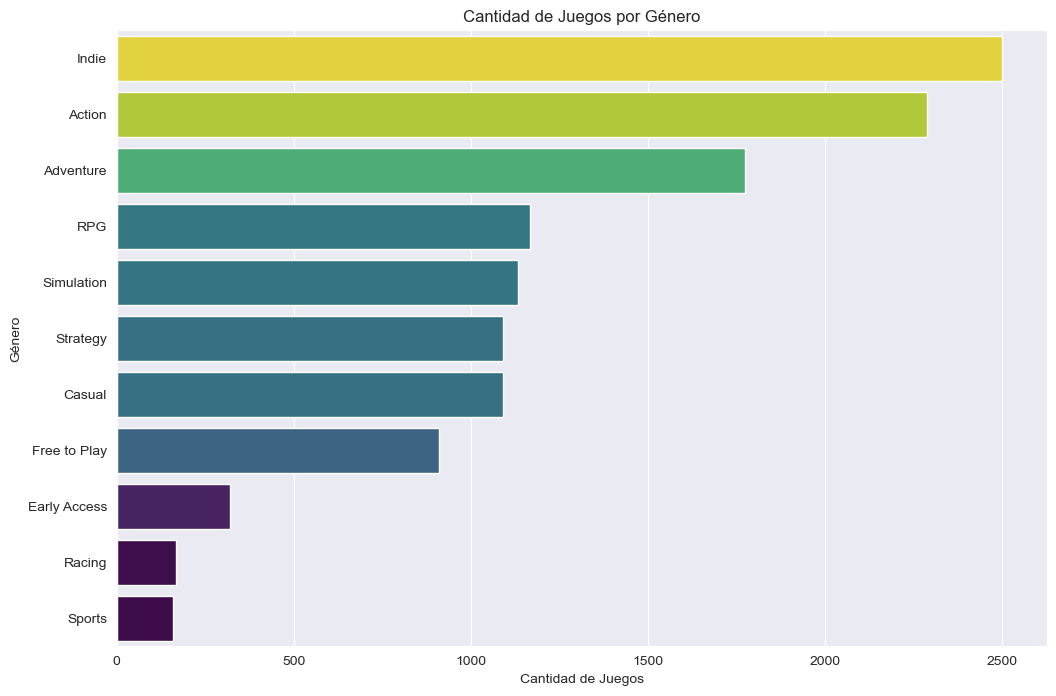

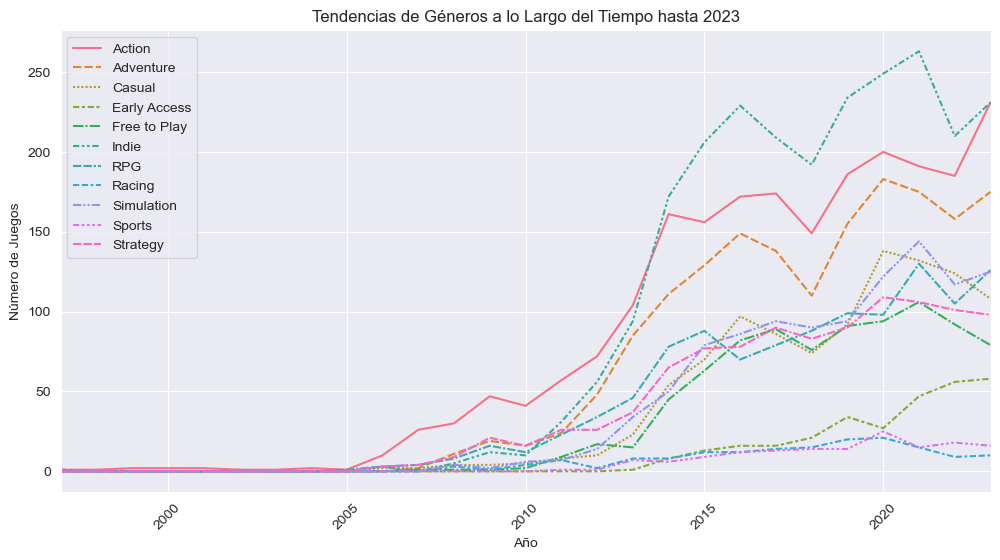

In [4]:
genre_columns = ['Action', 'Adventure', 'Casual', 'Early Access', 'Free to Play', 
                  'Indie', 'RPG', 'Racing', 'Simulation', 'Sports', 'Strategy']
# No se incluye Massively Multiplayer (MMO) debido a ser incorrectamente categorizado por parte de la mayoría de desarrolladores

genre_counts = df[genre_columns].sum().sort_values(ascending=False)
genre_counts_df = genre_counts.reset_index()
genre_counts_df.columns = ['Genre', 'Count']

# Visualización de los datos obtenidos

# 1) Distribución de Géneros
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Genre', hue='Count', data=genre_counts_df, palette="viridis", legend=False)
plt.title('Cantidad de Juegos por Género')
plt.xlabel('Cantidad de Juegos')
plt.ylabel('Género')
plt.show()

# 2) Tendencias Temporales de Géneros hasta 2023
df_filtered = df[df['year'] <= 2023]
genres_over_time = df_filtered.groupby(['year'])[genre_columns].sum() 
plt.figure(figsize=(12, 6))
sns.lineplot(data=genres_over_time)
plt.title('Tendencias de Géneros a lo Largo del Tiempo hasta 2023')
plt.ylabel('Número de Juegos')
plt.xlabel('Año')
plt.xticks(rotation=45)
plt.xlim(df_filtered['year'].min(), 2023) 
plt.show()

# PROCESO FUZZIFICACION

count     4417
unique       4
top          1
freq      1105
Name: popularity, dtype: int64
Popularidad difusa por género:
                   low    medium      high most_popular
Action        0.121596  0.527676  0.254085       medium
Adventure     0.177089  0.585944  0.187493       medium
Casual        0.236391  0.648211  0.116330       medium
Early Access  0.195833  0.605625  0.165000       medium
Free to Play  0.137212  0.544072  0.235346       medium
Indie         0.210631  0.621163  0.147242       medium
RPG           0.169666  0.578149  0.196401       medium
Racing        0.228797  0.640237  0.125444       medium
Simulation    0.181230  0.590291  0.182524       medium
Sports        0.197065  0.606918  0.163522       medium
Strategy      0.179346  0.588313  0.184785       medium


<Figure size 1000x800 with 0 Axes>

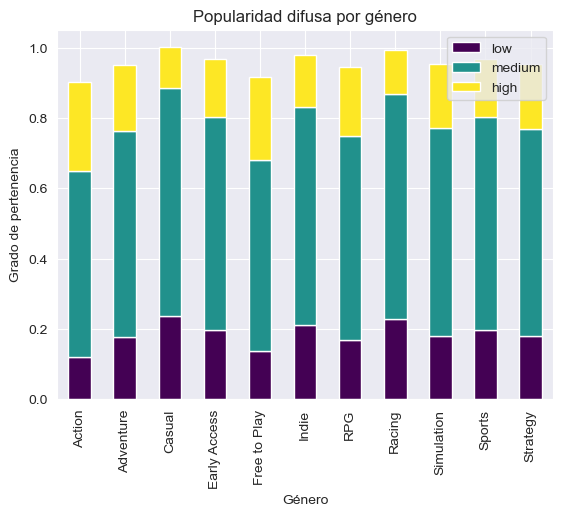

Lista de los géneros más populares en el año:
Género: Action, Popularidad: 1.94, Nivel: Medium
Género: Free to Play, Popularidad: 1.93, Nivel: Medium
Género: RPG, Popularidad: 1.92, Nivel: Medium
Género: Adventure, Popularidad: 1.91, Nivel: Medium
Género: Strategy, Popularidad: 1.91, Nivel: Medium
Género: Simulation, Popularidad: 1.91, Nivel: Medium
Género: Early Access, Popularidad: 1.90, Nivel: Medium
Género: Sports, Popularidad: 1.90, Nivel: Medium
Género: Indie, Popularidad: 1.89, Nivel: Medium
Género: Racing, Popularidad: 1.89, Nivel: Medium
Género: Casual, Popularidad: 1.88, Nivel: Medium


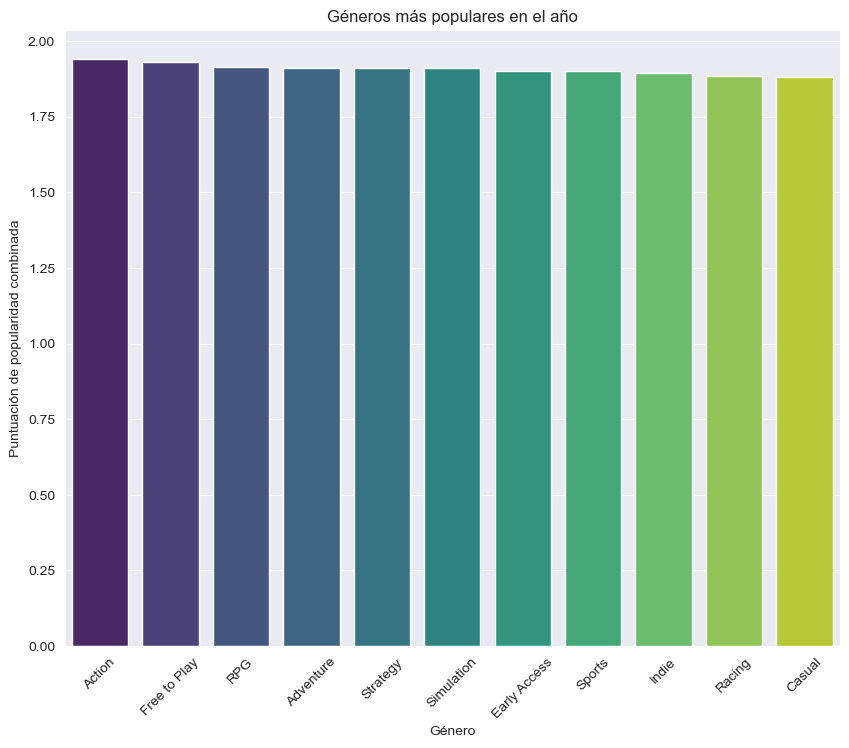

In [5]:
genre_columns = ['Action', 'Adventure', 'Casual', 'Early Access', 'Free to Play', 'Indie',
                  'RPG', 'Racing', 'Simulation', 'Sports', 'Strategy']
df_genres = df[genre_columns + ['popularity']]

# Método de fuzzificación: Función de membresía Triangular (Triangular Membership Function)
x_popularity = np.arange(1, 5, 1)
low = fuzz.trimf(x_popularity, [1, 1.5, 2.25])
medium = fuzz.trimf(x_popularity, [1.25, 2.25, 3.5])
high = fuzz.trimf(x_popularity, [2.5, 3.75, 4])
print(df_genres['popularity'].describe())

fuzzy_popularity_by_genre = pd.DataFrame(index=genre_columns, columns=['low', 'medium', 'high'])

for genre in genre_columns:
    genre_popularity = df_genres[df_genres[genre] == 1]['popularity'].astype(float)    
    if genre_popularity.empty:
        continue  
    genre_popularity_mean = genre_popularity.mean()
    fuzzy_popularity_by_genre.loc[genre, 'low'] = fuzz.interp_membership(x_popularity, low, genre_popularity_mean)
    fuzzy_popularity_by_genre.loc[genre, 'medium'] = fuzz.interp_membership(x_popularity, medium, genre_popularity_mean)
    fuzzy_popularity_by_genre.loc[genre, 'high'] = fuzz.interp_membership(x_popularity, high, genre_popularity_mean)

fuzzy_popularity_by_genre = fuzzy_popularity_by_genre.infer_objects(copy=False).fillna(0)


fuzzy_popularity_by_genre['most_popular'] = fuzzy_popularity_by_genre[['low', 'medium', 'high']].idxmax(axis=1)
print("Popularidad difusa por género:")
print(fuzzy_popularity_by_genre)

plt.figure(figsize=(10, 8))
fuzzy_popularity_by_genre[['low', 'medium', 'high']].plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Popularidad difusa por género')
plt.xlabel('Género')
plt.ylabel('Grado de pertenencia')
plt.legend(loc='upper right')
plt.show()

fuzzy_popularity_by_genre['popularity_score'] = (
    fuzzy_popularity_by_genre['low'] * 1 +
    fuzzy_popularity_by_genre['medium'] * 2 +
    fuzzy_popularity_by_genre['high'] * 3
)
fuzzy_popularity_by_genre_sorted = fuzzy_popularity_by_genre.sort_values(by='popularity_score', ascending=False)

print("Lista de los géneros más populares en el año:")
for idx, row in fuzzy_popularity_by_genre_sorted.iterrows():
    print(f"Género: {idx}, Popularidad: {row['popularity_score']:.2f}, Nivel: {row['most_popular'].capitalize()}")

plt.figure(figsize=(10, 8))
sns.barplot(x='index', y='popularity_score', hue='index', data=fuzzy_popularity_by_genre_sorted.reset_index(), palette="viridis", legend=False)
plt.title('Géneros más populares en el año')
plt.xlabel('Género')
plt.ylabel('Puntuación de popularidad combinada')
plt.xticks(rotation=45)
plt.show()


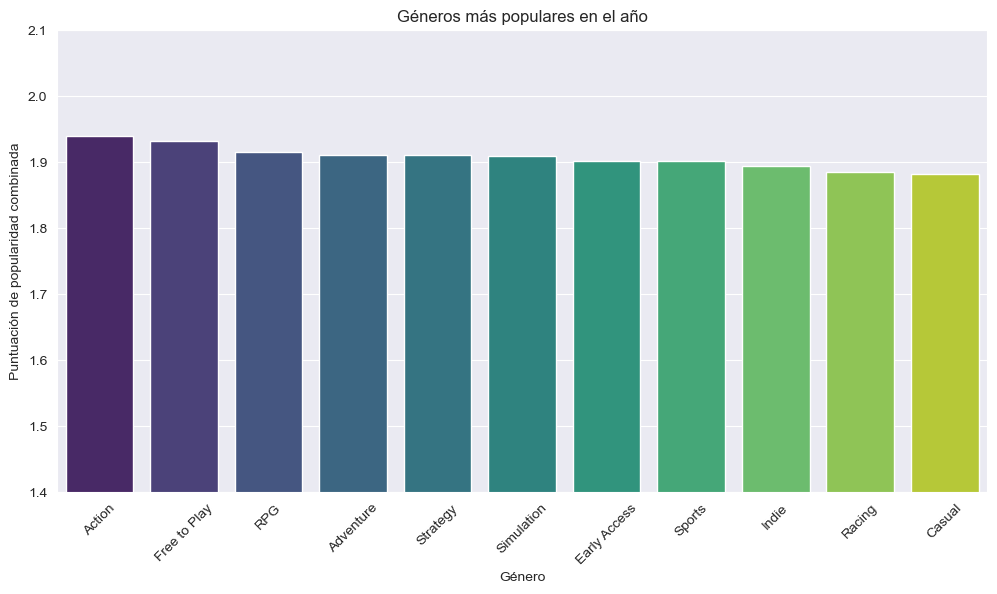

In [6]:
# Visualización de manera ampliada

plt.figure(figsize=(12, 6))
sns.barplot(x='index', y='popularity_score', hue='index', data=fuzzy_popularity_by_genre_sorted.reset_index(), palette="viridis", legend=False)
plt.title('Géneros más populares en el año')
plt.xlabel('Género')
plt.ylabel('Puntuación de popularidad combinada')
plt.ylim(1.4, 2.1)
plt.xticks(rotation=45)
plt.show()

# DEFUZZIFICACION

Valores defuzzificados de popularidad por género:
              defuzzified_popularity
Action                      2.146663
Free to Play                2.107059
RPG                         2.028315
Adventure                   2.010945
Strategy                    2.005710
Simulation                  2.001357
Early Access                1.968097
Sports                      1.965330
Indie                       1.935253
Racing                      1.896073
Casual                      1.880051


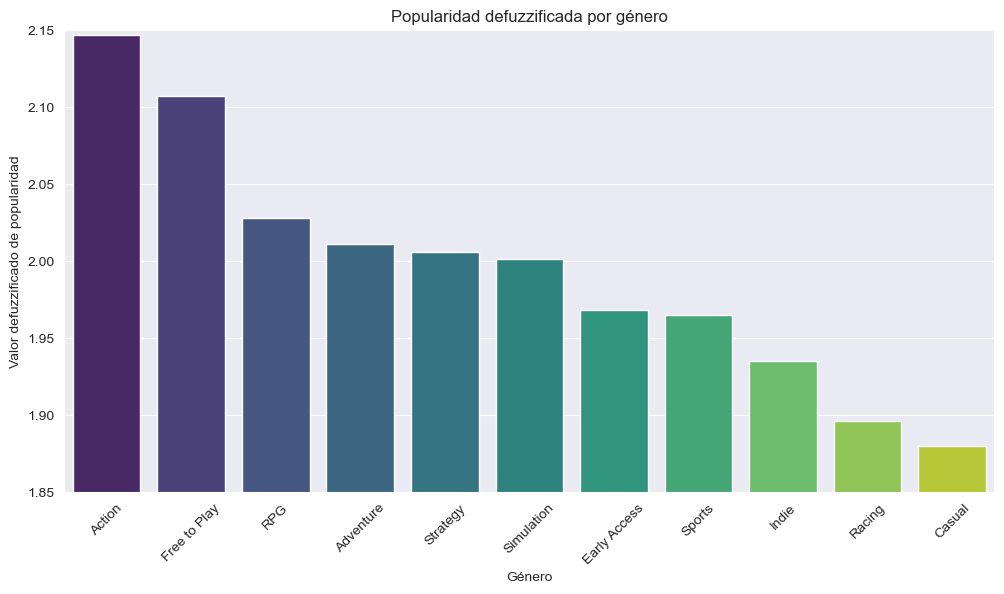

In [7]:
defuzzified_values = {}

# Método de defuzzificación: Promedio Ponderado (Weighted Average)
defuzzification_method = lambda low_membership, medium_membership, high_membership: (
    (1 * low_membership + 2 * medium_membership + 3 * high_membership) / (low_membership + medium_membership + high_membership) if (low_membership + medium_membership + high_membership) != 0 else 0
)

for genre in genre_columns:
    low_value = fuzzy_popularity_by_genre.loc[genre, 'low']
    medium_value = fuzzy_popularity_by_genre.loc[genre, 'medium']
    high_value = fuzzy_popularity_by_genre.loc[genre, 'high']
    
    defuzzified_value = defuzzification_method(low_value, medium_value, high_value)
    defuzzified_values[genre] = defuzzified_value

defuzzified_df = pd.DataFrame.from_dict(defuzzified_values, orient='index', columns=['defuzzified_popularity'])
defuzzified_df_sorted = defuzzified_df.sort_values(by='defuzzified_popularity', ascending=False)

print("Valores defuzzificados de popularidad por género:")
print(defuzzified_df_sorted)

defuzzified_df_sorted['hue'] = defuzzified_df_sorted.index

plt.figure(figsize=(12, 6))
sns.barplot(x=defuzzified_df_sorted.index, y='defuzzified_popularity', data=defuzzified_df_sorted, hue='hue', palette="viridis")
plt.title('Popularidad defuzzificada por género')
plt.xlabel('Género')
plt.ylabel('Valor defuzzificado de popularidad')
plt.xticks(rotation=45)
plt.ylim(1.85, 2.15)
plt.show()

In [8]:
# Se visualiza mediante JSON
defuzzified_df_sorted_json = defuzzified_df_sorted.reset_index().rename(columns={'index': 'genre'})
defuzzified_df_sorted_json = defuzzified_df_sorted_json[['genre', 'defuzzified_popularity']]
defuzzified_json = defuzzified_df_sorted_json.to_json(orient='records', indent=4)
print(defuzzified_json)


[
    {
        "genre":"Action",
        "defuzzified_popularity":2.1466626903
    },
    {
        "genre":"Free to Play",
        "defuzzified_popularity":2.1070594575
    },
    {
        "genre":"RPG",
        "defuzzified_popularity":2.0283147291
    },
    {
        "genre":"Adventure",
        "defuzzified_popularity":2.0109452638
    },
    {
        "genre":"Strategy",
        "defuzzified_popularity":2.005709978
    },
    {
        "genre":"Simulation",
        "defuzzified_popularity":2.0013568521
    },
    {
        "genre":"Early Access",
        "defuzzified_popularity":1.9680965725
    },
    {
        "genre":"Sports",
        "defuzzified_popularity":1.9653304442
    },
    {
        "genre":"Indie",
        "defuzzified_popularity":1.9352534139
    },
    {
        "genre":"Racing",
        "defuzzified_popularity":1.8960729869
    },
    {
        "genre":"Casual",
        "defuzzified_popularity":1.8800507172
    }
]


In [9]:
# Se guarda el JSON en un archivo
output_file_path = 'games_popularity.json'

with open(output_file_path, 'w') as json_file:
    json_file.write(defuzzified_json)

print(f"Archivo guardado como: {output_file_path}")


Archivo guardado como: games_popularity.json
